# Этап L5

In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808302 sha256=00ac0bd5e433a1c17dd4a87aa342e9a7bf45bcb20edbffe58ecd918b276b637b
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
import gc
import pandas as pd
import numpy as np
from tqdm import tqdm
from random import sample

from lightfm.data import Dataset
from lightfm import LightFM
import lightgbm as lgbm

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import ndcg_score

In [ ]:
path = "/content/drive/MyDrive/WB School/data.csv.gzip"
interactions = pd.read_csv(path, compression="gzip")
interactions["order_ts"] = pd.to_datetime(interactions["order_ts"])

После оценки каждой модели следует перезагружать ядро.

# Вспомогательные функции

### Функции для подготовки данных.

Некоторые функции являются общими для всех моделей, поэтому введём их сразу. Остальные будем инициализировать по мере надобности.

Функция `train_test()` делит выборку на обучающую и тестовую в зависимости от модели, которую будем использовать. Для бустинга обучающую выборку надо будет поделить на train/test части ещё раз.

In [ ]:
def train_test(interactions, for_boosting=False, q=0.7, threshold="2023-02-28 23:59:59.947831"):

  # Обучающая выборка - 2 месяца, тестовая - 1 последний месяц.
  train = interactions[interactions.order_ts <= threshold]
  test = interactions[interactions.order_ts > threshold]

  # Оставляем только "тёплых" пользователей и те товары, взаимодействия с которыми были в train периоде.
  test = test[test["user_id"].isin(train["user_id"].unique())]
  test = test[test["item_id"].isin(train["item_id"].unique())]

  # Если пользователь оформил заказ сразу на несколько единиц товара, то каждое из них является отдельным
  # наблюдением, и чтобы избежать переобучение под такие товары, уберём полные дубликаты.
  train = train.drop_duplicates()
  test = test.drop_duplicates()

  # Для гибридной модели глобальную обучающую выборку разделим на 2 части в соотношении 70:30.
  if for_boosting == True:
    lfm_threshold = train["order_ts"].quantile(q=q, interpolation="nearest")

    lfm_train = train[(train["order_ts"] <= lfm_threshold)]
    lfm_pred = train[(train["order_ts"] > lfm_threshold)]

    lfm_pred = lfm_pred[lfm_pred["user_id"].isin(lfm_train["user_id"].unique())]
    lfm_pred = lfm_pred[lfm_pred["item_id"].isin(lfm_train["item_id"].unique())]

    lfm_train = lfm_train.groupby(["user_id", "item_id"], as_index=False).count() \
        .rename(columns={"order_ts": "amount"})

    lfm_pred = lfm_pred.groupby(["user_id", "item_id"], as_index=False).count() \
        .rename(columns={"order_ts": "amount"})

    test = lfm_pred.groupby(["user_id", "item_id"], as_index=False).count() \
        .rename(columns={"order_ts": "amount"})

    return lfm_train, lfm_pred, test

  elif for_boosting == False:
    train = train.groupby(["user_id", "item_id"], as_index=False).count() \
        .rename(columns={"order_ts": "amount"})

    test = test.groupby(["user_id", "item_id"], as_index=False).count() \
        .rename(columns={"order_ts": "amount"})

    return train, test

Функция `lists_to_arrays()` преобразует данные к нужному для вычисления метрик виду.

In [ ]:
def lists_to_arrays(ranks, relevances, recommended_items_ids, relevant_items_ids):
  ranks_array = list()
  relevances_array = list()
  recommended_items_ids_array = list()
  relevant_items_ids_array = list()

  for i in tqdm(range(len(ranks))):
    rank = np.array(ranks[i]).astype(float)
    ranks_array.append(rank)

    rel = np.array(relevances[i]).astype(int)
    relevances_array.append(rel)

    rec_items = np.array(recommended_items_ids[i]).astype(int)
    recommended_items_ids_array.append(rec_items)

    rel_items = np.array(relevant_items_ids[i]).astype(int)
    relevant_items_ids_array.append(rel_items)

  ranks_array = np.array(ranks_array)
  relevances_array = np.array(relevances_array)
  recommended_items_ids_array = np.array(recommended_items_ids_array)
  relevant_items_ids_array = np.array(relevant_items_ids_array)

  return ranks_array, relevances_array, recommended_items_ids_array, relevant_items_ids_array

Функция `extract_vectors()` достаёт векторы рангов, релевантностей, id рекомендованных товаров и id релевантных товаров из результирующего на предыдущем шаге датафрейма, а затем преобразует к нужному для вычисления метрик формату.

In [ ]:
def extract_vectors(predictions, test, rank_column_name="rank"):

  ranks = predictions.groupby("user_id")[rank_column_name].apply(list).values
  relevances = predictions.groupby("user_id")["relevance"].apply(list).values
  recommended_items_ids = predictions.groupby("user_id")["item_id"].apply(list).values
  relevant_items_ids = test.groupby("user_id")["item_id"].apply(list).values

  ranks, relevances, recommended_items_ids, relevant_items_ids = lists_to_arrays(
      ranks,
      relevances,
      recommended_items_ids,
      relevant_items_ids
  )
  return ranks, relevances, recommended_items_ids, relevant_items_ids

Функция `drop_outlier_items()` исключает из выборки самые популярные товары.

In [ ]:
def drop_outlier_items(df, k=20):
  items_df = df.drop(columns="order_ts").groupby("item_id", as_index=False) \
        .count().rename(columns={"user_id": "amount"}).sort_values("amount", ascending=False)
  items = list(train_items.item_id.values[:k])
  df = df[~df["item_id"].isin(items)]

  return df

## Функции для вычисления метрик

### MAP@k

Функция `user_precision()` вычисляет значение AveragePrecision@k для одного пользователя и нужна для вычисления MeanAveragePrecision@k.

In [ ]:
def user_average_precision(user_relevances, k=20):
  if user_relevances[:k].sum() == 0:
    return 0
  else:
    # Считаем значение Average Precision@k для одного пользовтаеля.
    average_precision_list = list()

    for k_items in range(1, (k + 1)):
      precision = user_relevances[:k_items].sum()
      precision /= len(user_relevances[:k_items])
      average_precision_list.append(precision)

    average_precision_array = np.array(average_precision_list)
    average_precision = average_precision_array * user_relevances[:k]
    average_precision = average_precision.sum()
    average_precision /= user_relevances[:k].sum()

    return average_precision

Функция `get_map()` считает MeanAveragePrecision@k.

In [ ]:
def get_map(relevances, k=20):
  mean_average_precision = 0
  n = len(relevances)

  for i in tqdm(range(n)):
    average_precision = user_average_precision(relevances[i], k)
    mean_average_precision += average_precision

  return mean_average_precision / n

### MAR@k

Функция `eval_single()` считает значение Recal@k для одного пользователя.

In [ ]:
def eval_single(recommended_items_ids, relevant_items_ids, k=20):
  recall_at_k = sum(
      [
          1
          for rec_item in recommended_items_ids[:k]
          if rec_item in relevant_items_ids
      ]
  ) / min(len(relevant_items_ids), k)

  return recall_at_k

Функция `user_average_recall()` считает AverageRecall@k одного пользователя.

In [ ]:
def user_average_recall(user_relevances_recommended, recommended_items_ids, relevant_items_ids, k=20):
  if user_relevances_recommended[:k].sum() == 0:
    return 0
  else:
    average_recall_list = list()

    for k_items in range(1, (k + 1)):
      recall_at_k = eval_single(recommended_items_ids, relevant_items_ids, k_items)
      average_recall_list.append(recall_at_k)

    average_recall_array = np.array(average_recall_list)
    average_recall_array = average_recall_array * user_relevances_recommended[:k]
    average_recall = average_recall_array.sum()
    average_recall /= min(len(relevant_items_ids), k)

    return average_recall

Функция `get_mar()` считает MeanAverageRecall@k.

In [ ]:
def get_mar(relevances_recommended, recommended_items_ids, relevant_items_ids, k=20):
  mean_average_recall = 0
  n = len(relevances_recommended)

  for i in tqdm(range(n)):
    average_recall = user_average_recall(relevances_recommended[i], recommended_items_ids[i], relevant_items_ids[i], k)
    mean_average_recall += average_recall

  return mean_average_recall / n

### NDCG@k

In [ ]:
def get_ndcg(ranks_array, relevances_array, is_higher_better=False, k=20):
  n = len(ranks_array)
  ndcg = 0

  # Если на вход подаются скоры, а не ранги, то необходимо указать параметр is_higher_better = True.
  if is_higher_better == False:
    for i in tqdm(range(n)):
      rank = k - ranks_array[i]
      ndcg += ndcg_score([relevances_array[i]], [rank], k=k)
    return ndcg / n

  elif is_higher_better == True:
    for i in tqdm(range(n)):
      ndcg += ndcg_score([relevances_array[i]], [ranks_array[i]], k=k)
    return ndcg / n

### 3 в 1

Функция `get_metrics()` считает MAP@k, MAR@k и NDCG@k модели. Выдаёт словарь, где ключи - названия метрик, значения - метрики.

In [ ]:
def get_metrics(ranks, relevances, recommended_items_ids, relevant_items_ids, is_higher_better=False, k=20):
  metrics = dict()

  key = "MAP@" + str(k)
  metrics[key] = get_map(relevances, k)

  key = "MAR@" + str(k)
  metrics[key] = get_mar(relevances, recommended_items_ids, relevant_items_ids, k)

  key = "NDCG@" + str(k)
  metrics[key] = get_ndcg(ranks, relevances, is_higher_better, k)

  return metrics

# Popularity Based Recommender

In [ ]:
threshold = "2023-02-28 23:59:59.947831"
train = interactions[interactions.order_ts <= threshold]
test = interactions[interactions.order_ts > threshold]

Функция `predict_popular()` рекомендует товары на основе их популярности. Сначала всем пользователям рекомендуются преобретёнными в train периоде товары. Затем, если пользователь в течение train периода заказал менее k товаров, список дополняется соотствующим количеством товаров, наиболее популярных среди пользователей train периода.

In [ ]:
def predict_popular(train, test, k=20):
  test = test[test["user_id"].isin(train["user_id"].unique())]
  test = test[test["item_id"].isin(train["item_id"].unique())]

  # Приготовим k наиболее популярных товаров среди всех пользователей train периода.
  train_items = train.drop(columns="order_ts").groupby("item_id", as_index=False) \
      .count().rename(columns={"user_id": "amount"}).sort_values("amount", ascending=False)
  items = list(train_items.item_id.values[:k])

  # Заполняем списки рекомендаций пользователей наиболее популярными
  # товарами среди всех пользователей train периода.
  predictions_dict = dict()
  users = test["user_id"].unique()
  for user in tqdm(users):
    predictions_dict[user] = items

  # На основе построенного словаря с рекомедациями составляем датафрейм.
  predictions_df = pd.DataFrame({"user_id": users})
  predictions_df["item_id"] = predictions_dict.values()
  predictions_df = predictions_df.explode("item_id")
  predictions_df["rank"] = predictions_df.groupby("user_id").cumcount() + 1

  test = test.groupby(["user_id", "item_id"], as_index=False).count() \
      .rename(columns={"order_ts": "amount"})
  test = test.drop(columns="amount")
  test["relevance"] = 1

  predictions_df = pd.merge(predictions_df, test, on=["user_id", "item_id"], how="left")
  predictions_df["relevance"] = predictions_df["relevance"].fillna(0)
  predictions_df["relevance"] = predictions_df["relevance"].astype(int)

  return predictions_df, test

In [ ]:
predictions, test = predict_popular(train, test, k=20)

100%|██████████| 720401/720401 [00:00<00:00, 1586850.52it/s]


In [ ]:
ranks_array, relevances_array, recommended_items_ids_array, relevant_items_ids_array = extract_vectors(predictions, test)

100%|██████████| 720409/720409 [00:12<00:00, 55455.79it/s]
<ipython-input-5-e0bad87030c7>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ranks_array = np.array(ranks_array)
<ipython-input-5-e0bad87030c7>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  relevances_array = np.array(relevances_array)
<ipython-input-5-e0bad87030c7>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must sp

In [ ]:
get_metrics(
    ranks_array,
    relevances_array,
    recommended_items_ids_array,
    relevant_items_ids_array,
    is_higher_better=False,
    k=20
)

100%|██████████| 720401/720401 [05:18<00:00, 2261.95it/s]


{'MAP@20': 0.10148372261357151,
 'MAR@20': 0.05323537359906245,
 'NDCG@20': 0.17946508838748196}

# LightFM models

In [ ]:
train, test = train_test(interactions)

## Преобразование данных

Функция `transform_interactions()` понадобится для преобразования данных.

In [ ]:
def transform_interactions(interactions_grouped):
  return interactions_grouped[["user_id", "item_id", "amount"]].itertuples(index=False)

Функция `make_dataset()` преобразует исходные данные к LightFM.Dataset формату и создаёт отображение для оценки качества LightFM моделей.

In [ ]:
def make_dataset(train, test):
  # Создаём обучающий и тестовый датасеты.
  user_ids_buffered = (x for x in train["user_id"].unique())
  item_ids_buffered = (x for x in train["item_id"].unique())

  dataset = Dataset()

  dataset.fit(
    users=user_ids_buffered,
    items=item_ids_buffered
  )

  interaction_matrix_train, _ = dataset.build_interactions(
      transform_interactions(train))

  interaction_matrix_test, _ = dataset.build_interactions(
      transform_interactions(test))

  # Сохраняем отображение.
  lightfm_mapping = dataset.mapping()
  lightfm_mapping = {"users_mapping": lightfm_mapping[0],
                     "items_mapping": lightfm_mapping[2]}

  lightfm_mapping["users_inv_mapping"] = {v: k for k, v in lightfm_mapping["users_mapping"].items()}
  lightfm_mapping["items_inv_mapping"] = {v: k for k, v in lightfm_mapping["items_mapping"].items()}

  all_cols = list(lightfm_mapping["items_mapping"].values())

  return interaction_matrix_train, interaction_matrix_test, lightfm_mapping, all_cols

In [ ]:
interaction_matrix_train, interaction_matrix_test, lightfm_mapping, all_cols = make_dataset(train, test)

Сверим размерности:

In [ ]:
interaction_matrix_train.shape, interaction_matrix_test.shape

((941415, 6415), (941415, 6415))

## Оценка моделей

Обучим модель k-OS WARP.

In [ ]:
model_warp_kos = LightFM(
    no_components=50,
    k=3,
    n=11,
    learning_schedule="adagrad",
    loss="warp-kos",
    learning_rate=0.027,
    item_alpha=0.00001,
    user_alpha=0.00014,
    max_sampled=40)

model_warp_kos.fit(interaction_matrix_train, epochs=20)

Модели матричной факторизации склонны к переобучению под популярные товары, поэтому для сохранения разнообразия смешения айтемов, полученные в LightFM-модели, необходимо занулить.

In [ ]:
model_warp_kos.item_biases = np.zeros_like(model_warp_kos.item_biases)

Функция `generate_lightfm_recs_mapper()` является вспомогательной для функции отбора кандидатов от модели, следующей за ней.

In [ ]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, user_features, item_features, N, user_mapping, item_inv_mapping, num_threads=4):
  def _recs_mapper(user):
    user_id = user_mapping[user]
    recs = model.predict(user_id, item_ids, user_features=user_features, item_features=item_features, num_threads=num_threads)

    additional_N = len(known_items[user_id]) if user_id in known_items else 0
    total_N = N + additional_N
    top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]

    final_recs = [item_inv_mapping[item] for item in top_cols]
    if additional_N > 0:
      filter_items = known_items[user_id]
      final_recs = [item for item in final_recs if item not in filter_items]
    return final_recs[:N]
  return _recs_mapper

Функция `predict_lightfm()` составляет рекомендации для пользователей из test периода на основе обученной LightFM-модели и проставляет соответствующие значения релевантности.

In [ ]:
def predict_lightfm(model, train, test, all_cols, lightfm_mapping, top_N=20, relevances_needed=True):

  # Создаём датафрейм, в котором будут храниться рекомендации для пользователей.
  predictions = pd.DataFrame({"user_id": test["user_id"].unique()})
  predictions = predictions[predictions["user_id"].isin(train["user_id"].unique())]
  known_items = train.groupby("user_id")["item_id"].apply(list).to_dict()

  # Собираем предсказания
  mapper = generate_lightfm_recs_mapper(
    model,
    item_ids=all_cols,
    known_items=known_items,
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping["users_mapping"],
    item_inv_mapping=lightfm_mapping["items_inv_mapping"],
    num_threads=20
  )

  predictions["item_id"] = predictions["user_id"].map(mapper)
  predictions = predictions.explode("item_id").reset_index(drop=True)
  predictions["rank"] = predictions.groupby("user_id").cumcount() + 1

  if relevances_needed == True:
    test = test.drop(columns="amount")
    test["relevance"] = 1
    predictions = pd.merge(predictions, test, on=["user_id", "item_id"], how="left")
    predictions["relevance"] = predictions["relevance"].fillna(0)
    predictions["relevance"] = predictions["relevance"].astype(int)

    return predictions

  elif relevances_needed == False:
    return predictions

In [ ]:
predictions = predict_lightfm(
    model_warp_kos,
    train, test,
    all_cols,
    lightfm_mapping,
    top_N=20,
    relevances_needed=True
)

In [ ]:
ranks_array, relevances_array, recommended_items_ids_array, relevant_items_ids_array = extract_vectors(predictions, test)

Метрики для k-OS WARP:

In [ ]:
get_metrics(
    ranks_array,
    relevances_array,
    recommended_items_ids_array,
    relevant_items_ids_array,
    k=20
)

100%|██████████| 720401/720401 [04:30<00:00, 2660.40it/s]


{'MAP@20': 0.13684640231211853,
 'MAR@20': 0.05819866645922324,
 'NDCG@20': 0.2126102943916515}

Посчитаем метрики для WARP.

In [ ]:
model_warp = LightFM(
    no_components=50,
    learning_schedule="adagrad",
    loss="warp",
    learning_rate=0.04,
    item_alpha=0.0001,
    user_alpha=0.00005,
    max_sampled=40
)

model_warp.fit(interaction_matrix_train, epochs=20)

In [ ]:
model_warp.item_biases = np.zeros_like(model_warp.item_biases)

In [ ]:
predictions = predict_lightfm(
    model_warp,
    train, test,
    all_cols,
    lightfm_mapping,
    top_N=20,
    relevances_needed=True
)

In [ ]:
ranks_array, relevances_array, recommended_items_ids_array, relevant_items_ids_array = extract_vectors(predictions, test)

In [ ]:
get_metrics(
    ranks_array,
    relevances_array,
    recommended_items_ids_array,
    relevant_items_ids_array,
    k=20
)

100%|██████████| 720401/720401 [04:39<00:00, 2581.21it/s]


{'MAP@20': 0.10228329292253233,
 'MAR@20': 0.04826692286324861,
 'NDCG@20': 0.18212598165419863}

# LFM + LGBM

## Обучение бустинга

Подготовим данные для обучения 2 моделей отбора кандидатов.

In [ ]:
lfm_train, lfm_pred, test = train_test(interactions, for_boosting=True)

In [ ]:
interaction_matrix_train, interaction_matrix_test, lightfm_mapping, all_cols = make_dataset(lfm_train, lfm_pred)

Обучим LightFM-модели.

In [ ]:
model_warp_kos = LightFM(
    no_components=120,
    k=3,
    n=11,
    learning_schedule="adagrad",
    loss="warp-kos",
    learning_rate=0.027,
    item_alpha=0.00001,
    user_alpha=0.00014,
    max_sampled=90)

model_warp_kos.fit(interaction_matrix_train, epochs=20)


model_warp = LightFM(
    no_components=120,
    learning_schedule="adagrad",
    loss="warp",
    learning_rate=0.04,
    item_alpha=0.0001,
    user_alpha=0.00005,
    max_sampled=90
)

model_warp.fit(interaction_matrix_train, epochs=20)

Занулим смещения айтемов, чтобы не переобучиться под популярные товары.

In [ ]:
model_warp_kos.item_biases = np.zeros_like(model_warp_kos.item_biases)
model_warp.item_biases = np.zeros_like(model_warp.item_biases)

Функция `candidates_relevances()` объединяет кандидатов от LightFM-моделей первого уровня и проставляет значения релевантности.

In [ ]:
def candidates_relevances(model_first, model_second, lfm_train, lfm_pred, test, all_cols, lightfm_mapping, top_N=30):
  # Отбираем кандидатов
  predictions_first = predict_lightfm(
      model_warp_kos,
      lfm_train,
      lfm_pred,
      all_cols,
      lightfm_mapping,
      top_N=top_N,
      relevances_needed=False
  )

  predictions_second = predict_lightfm(
      model_warp,
      lfm_train,
      lfm_pred,
      all_cols,
      lightfm_mapping,
      top_N=top_N,
      relevances_needed=False
  )

  predictions_first = predictions_first.rename(columns={"rank": "rank_first"})
  predictions_second = predictions_second.rename(columns={"rank": "rank_second"})

  # Объединяем наборы кандидатов.
  predictions_first = pd.merge(
      predictions_first,
      predictions_second,
      on=["user_id", "item_id"],
      how="outer"
  )

  # Проставляем значения релевантности.
  test = test.drop(columns="amount")
  test["relevance"] = 1
  predictions_first = pd.merge(predictions_first, test, on=["user_id", "item_id"], how="left")
  predictions_first["relevance"] = predictions_first["relevance"].fillna(0)
  predictions_first["relevance"] = predictions_first["relevance"].astype(int)

  return predictions_first

In [ ]:
predictions_train = candidates_relevances(
    model_warp_kos,
    model_warp,
    lfm_train,
    lfm_pred,
    test,
    all_cols,
    lightfm_mapping,
    top_N=30
)

<ipython-input-27-b3d72cce3816>:27: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  predictions_first = pd.merge(


Составим датасет для обучения бустинга.

Функция `get_query_id()` нужна для разбиения пользователей по группам для бустинга.

In [ ]:
def get_query_id(df):
  query_map = {}

  for query_id, user_id in enumerate(df["user_id"].unique()):
    query_map[user_id] = query_id

  query_id = df["user_id"].map(query_map)

  return query_id

Функция `positive_negative_sampling()` делает семплирование релевантных и нерелевантных взаимодействий в указанном соотношении и составляет датасеты для обучения и валидации бустинга.

In [ ]:
def positive_negative_sampling(candidates, lfm_pred, pos_neg_ratio=0.2, val_users_size=0.3):
  # Семплируем в требуемом соотношении.
  pos = candidates.merge(
      lfm_pred,
      on=["user_id", "item_id"],
      how="inner"
  )
  pos["target"] = 1

  neg = candidates.set_index(["user_id", "item_id"]) \
          .join(lfm_pred.set_index(["user_id", "item_id"]))
  neg = neg.reset_index()

  neg_sample_frac = len(pos) / (len(neg) * pos_neg_ratio)
  neg = neg.sample(frac=neg_sample_frac)
  neg["target"] = 0

  # Собираем датасеты для обучения и валидации, т.е. для механизма early_stopping.
  train_users, val_users = train_test_split(
      lfm_pred["user_id"].unique(),
      random_state=42,
      test_size=val_users_size
  )

  select_col = ["user_id", "item_id", "rank_first", "rank_second", "target"]
  lgbm_train = shuffle(pd.concat([pos[pos["user_id"].isin(train_users)],
                                  neg[neg["user_id"].isin(train_users)]])[select_col])
  lgbm_val = shuffle(pd.concat([pos[pos["user_id"].isin(val_users)],
                                neg[neg["user_id"].isin(val_users)]])[select_col])

  # Делаем разбиение по пользователям.
  lgbm_train["query_id"] = get_query_id(lgbm_train)
  lgbm_val["query_id"] = get_query_id(lgbm_val)

  train_group = lgbm_train["query_id"].value_counts().sort_index().values
  val_group = lgbm_val["query_id"].value_counts().sort_index().values

  del lgbm_train["query_id"]
  del lgbm_val["query_id"]
  gc.collect()

  # Убедимся, что с типом данных всё в порядке.
  lgbm_train["item_id"] = lgbm_train["item_id"].astype(np.int64)
  lgbm_val["item_id"] = lgbm_val["item_id"].astype(np.int64)

  # Преобразуем данные для обучения и механизма ранней остановки к нужному для lgbm формату.
  train_lgbm_dataset = lgbm.Dataset(
      data=lgbm_train.drop(columns="target"), label=lgbm_train["target"],
      group=train_group
  )

  val_lgbm_dataset = lgbm.Dataset(
      data=lgbm_val.drop(columns="target"), label=lgbm_val["target"],
      group=val_group
  )

  return train_lgbm_dataset, val_lgbm_dataset

In [ ]:
train_lgbm_dataset, val_lgbm_dataset = positive_negative_sampling(
    predictions_train,
    lfm_pred,
    pos_neg_ratio=0.3,
    val_users_size=0.2
)

In [ ]:
del predictions_train

gc.collect()

0

Обучим бустинг.

In [ ]:
params = {
    "objective": "lambdarank",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 30,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "first_metric_only": True,
    "metric": (
        "lambdarank", "map", "auc"
    ),
    "reg_lambda": 0.001,
    "eval_at": (20)
}

In [ ]:
booster = lgbm.train(
    params=params,
    train_set=train_lgbm_dataset,
    num_boost_round=1500,
    valid_sets=[train_lgbm_dataset, val_lgbm_dataset],
    early_stopping_rounds=200,
    verbose_eval=20
)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 400706, total data: 2879509
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 2879509, number of used features: 4
[LightGBM] [Info] Total groups: 171750, total data: 1232861
Training until validation scores don't improve for 100 rounds
[20]	training's ndcg@20: 0.809139	training's map@20: 0.72895	training's auc: 0.697773	valid_1's ndcg@20: 0.8077	valid_1's map@20: 0.727064	valid_1's auc: 0.695817
[40]	training's ndcg@20: 0.811632	training's map@20: 0.73226	training's auc: 0.702439	valid_1's ndcg@20: 0.809971	valid_1's map@20: 0.730115	valid_1's auc: 0.700494
[60]	training's ndcg@20: 0.813192	training's map@20: 0.734358	training's auc: 0.706132	valid_1's ndcg@20: 0.81149	valid_1's map@20: 0.732169	valid_1's auc: 0.704099
[80]	training's ndcg@20: 0.814381

## Оценка гибридной модели

Отберём по 30 кандидатов для каждого пользователя для предсказания на test периоде.

In [ ]:
predictions_first_test = predict_lightfm(
    model_warp_kos,
    lfm_train,
    test,
    all_cols,
    lightfm_mapping,
    top_N=30,
    relevances_needed=False
)

In [ ]:
del model_warp_kos

gc.collect()

In [ ]:
predictions_second_test = predict_lightfm(
    model_warp,
    lfm_train,
    test,
    all_cols,
    lightfm_mapping,
    top_N=30,
    relevances_needed=False
)

In [ ]:
del model_warp
del lfm_train, all_cols, lightfm_mapping

gc.collect()

0

In [ ]:
predictions_first_test = predictions_first_test.rename(columns={"rank": "rank_first"})
predictions_second_test = predictions_second_test.rename(columns={"rank": "rank_second"})

Объединим кандидатов.

In [ ]:
predictions_test = pd.merge(
    predictions_first_test,
    predictions_second_test,
    on=["user_id", "item_id"],
    how="outer"
)

<ipython-input-44-d6a3b5f68fa4>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  predictions_test = pd.merge(predictions_first_test, predictions_second_test, on=["user_id", "item_id"], how="outer")


In [ ]:
predictions_test["item_id"] = predictions_test["item_id"].astype(np.int64)

In [ ]:
del predictions_first_test, predictions_second_test, lfm_pred
del train_test, transform_interactions, make_dataset, generate_lightfm_recs_mapper
del predict_lightfm, candidates_relevances, get_query_id, positive_negative_sampling
del interaction_matrix_train, interaction_matrix_test, interactions, params, path, train_lgbm_dataset, val_lgbm_dataset

gc.collect()

0

Посчитаем прогнозы скоров от бустинга.

In [ ]:
predictions_test["lgbm_pred"] = booster.predict(predictions_test)

In [ ]:
del booster

gc.collect()

0

Проставим значения релевантности.

In [ ]:
test = test.drop(columns="amount")
test["relevance"] = 1

In [ ]:
predictions_test = predictions_test.sort_values(
    by=["user_id", "lgbm_pred"], ascending=[True, False])

In [ ]:
predictions_test = pd.merge(
    predictions_test,
    test,
    on=["user_id", "item_id"],
    how="left"
)

In [ ]:
predictions_test["relevance"] = predictions_test["relevance"].fillna(0)
predictions_test["relevance"] = predictions_test["relevance"].astype(int)

In [ ]:
predictions_test.head()

,user_id,item_id,rank_first,rank_second,lgbm_pred,relevance
0,2,1571,8.0,NaN,0.774534,0
1,2,406,6.0,NaN,0.614867,0
2,2,593,2.0,NaN,0.485930,0
3,2,360,NaN,25.0,0.443464,0
4,2,504,1.0,NaN,0.381070,0


In [ ]:
predictions_test.user_id.nunique(), predictions_test.item_id.nunique()

(573031, 1137)

Достанем необходимые векторы значений.

In [ ]:
preds_array, relevances_array, recommended_items_ids_array, relevant_items_ids_array = extract_vectors(
    predictions_test,
    test,
    rank_column_name="lgbm_pred"
)

100%|██████████| 573031/573031 [00:14<00:00, 38234.13it/s]
<ipython-input-5-e0bad87030c7>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ranks_array = np.array(ranks_array)
<ipython-input-5-e0bad87030c7>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  relevances_array = np.array(relevances_array)
<ipython-input-5-e0bad87030c7>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must sp

Наконец, посмотрим на качество бустинга.

In [ ]:
get_metrics(
    preds_array,
    relevances_array,
    recommended_items_ids_array,
    relevant_items_ids_array,
    is_higher_better=True,
    k=20
)

100%|██████████| 573031/573031 [02:57<00:00, 3227.59it/s]


{'MAP@20': 0.18398346761769038,
 'MAR@20': 0.13874130064485937,
 'NDCG@20': 0.2579615685570055}

# Результаты

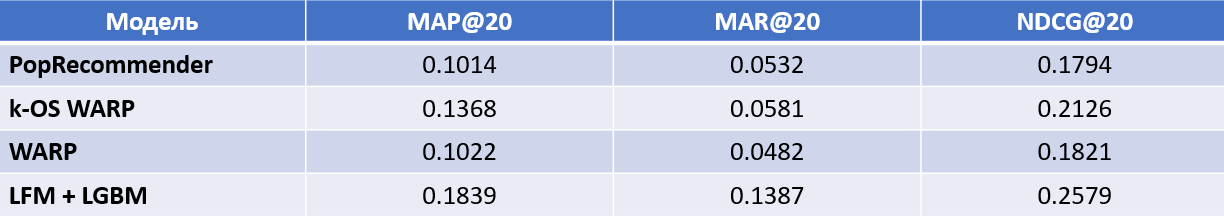